# Time series classification using Convolutional Neural Network and spectrogram images



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Import_functions import *
from CMSIS_Functions import *
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import plotly.express as px
import plotly.graph_objects as go
import tqdm as tqdm
lb = preprocessing.LabelBinarizer()

### Loading and sorting data for image recognition deep learning algorithm

Load data coming from a 3-axes accelerometer attached to a motor. The aim of this study it to classify the time series acceleration data in four classes:
- Slow
- Fast
- Slow with disturbance
- Fast with disturbance 

Data have been collected using the highest available sampling frequency of 6667 Hz.
It is possible to study the classification problem considering also lower sampling frequency adjusting the Resampling_frequency parameter with one of the following frequency values corresponding to the available STWIN output data rate:
- 12.5
- 26
- 52
- 104
- 208
- 416
- 833
- 1667
- 3332
- 6667

<br>

The following function prepares the accelerometric data into X matrixes (one for each class) ready for the training, depending on the network used the images must have some specific interval values. In this example the Incepetion V3 network has been used, so the spectrogram matrix values must be between -1 and 1 as explained here https://keras.io/api/applications/inceptionv3/

<br>

Different types of pre-trained networks can be used, each of them has different input specifications: https://keras.io/api/applications/

In [12]:
def CNN_Spectr_Imag_sorting_input_matrix(DataFrame,sampling_frequency ,shift_samples=64,window_length=512, sliding_samples=2):
    # shift_samples is the shifting number of samples for calculating the spectrum
    # sliding samples are the numer of samples for data augmentation

    fft_samples = int(window_length/2)
    signal_x  = np.array(DataFrame['A_'+'x'+' [g]'])
    signal_y  = np.array(DataFrame['A_'+'y'+' [g]'])
    signal_z  = np.array(DataFrame['A_'+'z'+' [g]'])

    signal_x = signal_x.reshape((len(signal_x),1))    
    signal_y = signal_y.reshape((len(signal_y),1))    
    signal_z = signal_z.reshape((len(signal_z),1))    

    signal = np.concatenate((signal_x,signal_y,signal_z), axis =1)
    signal=gravity_rotation(signal)

    Spectrogram_matrix_x  = CMSIS_PowerSpectrogram(signal[:,0], sampling_frequency,n_samples = window_length, shift_samples=shift_samples)
    Spectrogram_matrix_y  = CMSIS_PowerSpectrogram(signal[:,1], sampling_frequency,n_samples = window_length, shift_samples=shift_samples)
    Spectrogram_matrix_z  = CMSIS_PowerSpectrogram(signal[:,2], sampling_frequency ,n_samples = window_length, shift_samples=shift_samples)
    
    N=0
    while (Spectrogram_matrix_x.shape[1]-(N*sliding_samples+window_length)) > 0:
        N=N+1

    X_class=np.zeros((N,fft_samples,fft_samples,3))

    for ii in range(N):
        X_class[ii,:,:,0]=20*np.log10(Spectrogram_matrix_x[:,ii*sliding_samples:ii*sliding_samples+fft_samples])
        X_class[ii,:,:,1]=20*np.log10(Spectrogram_matrix_y[:,ii*sliding_samples:ii*sliding_samples+fft_samples])
        X_class[ii,:,:,2]=20*np.log10(Spectrogram_matrix_z[:,ii*sliding_samples:ii*sliding_samples+fft_samples])

        X_class[ii,:,:,0] = (X_class[ii,:,:,0] - X_class[ii,:,:,0].min())/ (X_class[ii,:,:,0].max() - X_class[ii,:,:,0].min())
        X_class[ii,:,:,1] = (X_class[ii,:,:,1] - X_class[ii,:,:,1].min())/ (X_class[ii,:,:,1].max() - X_class[ii,:,:,1].min())
        X_class[ii,:,:,2] = (X_class[ii,:,:,2] - X_class[ii,:,:,2].min())/ (X_class[ii,:,:,2].max() - X_class[ii,:,:,2].min())

        X_class[ii,:,:,0] = (X_class[ii,:,:,0] * 2)-1
        X_class[ii,:,:,1] = (X_class[ii,:,:,1] * 2)-1
        X_class[ii,:,:,2] = (X_class[ii,:,:,2] * 2)-1


    return X_class

In [16]:
# input parameter
Resampling_frequency = 1667       # resampling frequency
n_samples = 512                   # n_samples considered for spectrogra calculation
sliding_samples = 2             # n. of overlapped samples between two consecutive images for data augmentation purpose

df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = load_data(resampling_active=True, Resampling_frequency=Resampling_frequency)

X_S = CNN_Spectr_Imag_sorting_input_matrix(df_ACC_S,Resampling_frequency,64,n_samples,sliding_samples)
X_F = CNN_Spectr_Imag_sorting_input_matrix(df_ACC_F,Resampling_frequency,64,n_samples,sliding_samples)
X_SD = CNN_Spectr_Imag_sorting_input_matrix(df_ACC_SD,Resampling_frequency,64,n_samples,sliding_samples)
X_FD = CNN_Spectr_Imag_sorting_input_matrix(df_ACC_FD,Resampling_frequency,64,n_samples,sliding_samples)

Measured ODR: 6917.174621034457

ODR after resampling: 1667.0000000000002
2869
2868
2868
2869


<br>
<br>
<br>
<br>

### Plot some spectrogram images 

The following spectrogram images will be used for training a Convolutional Neural Network

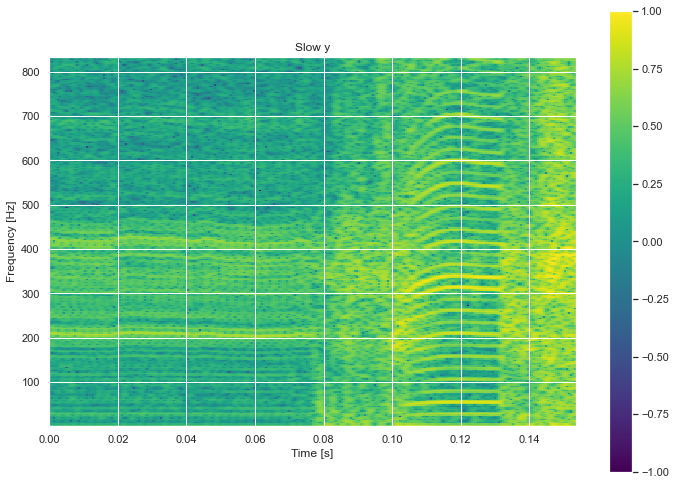

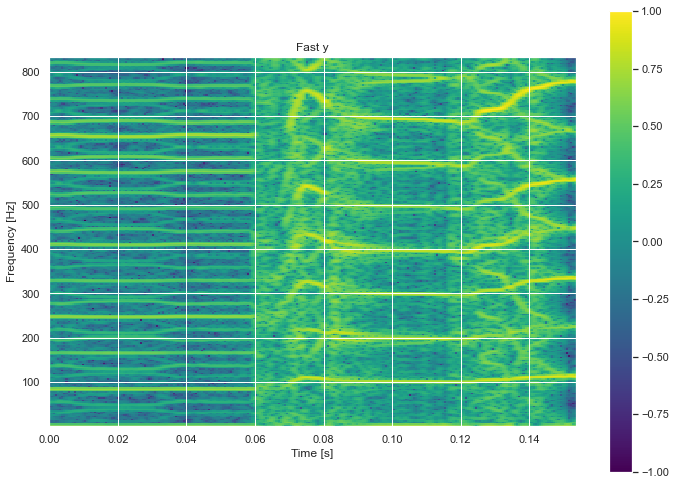

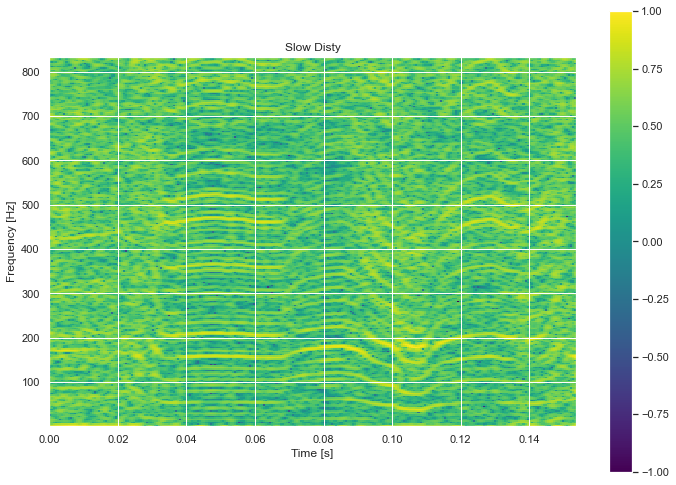

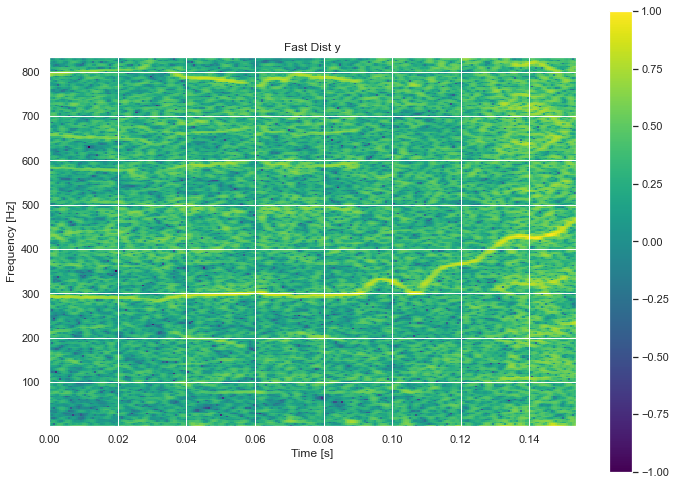

In [18]:
ax_S = show_specgram(X_S[10,:,:,1], 0.7, [0, X_S.shape[1]/Resampling_frequency, Resampling_frequency/2 ,1], cmin = -1, title='Slow '+'y')
ax_F = show_specgram(X_F[10,:,:,1], 0.7, [0, X_S.shape[1]/Resampling_frequency, Resampling_frequency/2 ,1], cmin = -1, title='Fast '+'y')
ax_SD = show_specgram(X_SD[10,:,:,1], 0.7, [0, X_S.shape[1]/Resampling_frequency, Resampling_frequency/2 ,1], cmin = -1, title='Slow Dist'+'y')
ax_FD = show_specgram(X_FD[10,:,:,1], 0.7, [0, X_S.shape[1]/Resampling_frequency, Resampling_frequency/2 ,1], cmin = -1, title='Fast Dist '+'y')


## Prepare dataset Train-Validation-Test  split

In [2]:
y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

X = np.concatenate((X_S,X_F,X_SD,X_FD),axis=0)
y = np.concatenate((y_S,y_F,y_SD,y_FD),axis=0)

# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]

# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb.fit(y)
y=lb.transform(y)

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

NameError: name 'X_S' is not defined

<br>
<br>
<br>
<br>
<br>
<br>


# Import ImageNet and train the imagenet with spectrum images

As base model a pre-trained model for image classification has been used. Over the base model a classification fully connected layers have been added in order to fit the classification to out problem.
With the variable n_trainable_layers it is possible to choose the n of trainable layers starting from the last one. The number of trainable/non trainable parameters can be checked with mode.summary

In [23]:
n_traineble_layers = 10

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape= (X.shape[1],X.shape[2],X.shape[3]))

for ii in range(len(base_model.layers)-20):
    base_model.layers[ii].trainable = False

# add a global spatial average pooling layer
x = base_model.output

# let's add a fully-connected layer
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 255, 255, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 255, 255, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [25]:
learningRate = 1e-13
batchSize = 128
# Train the model 
model, score = evaluate_model(trainX, trainY ,
                validationX, validationY, 
                testX, testY, 
                model,
                learningRate = learningRate,
                batchSize = batchSize,
                nEpochs = 15,
                verbosity = 1,
                learning_curves = True, ConfusionMatrix = True)

Train on 108 samples, validate on 36 samples
Epoch 1/15
